In [2]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "04_grpc_max_throughput"
file_prefix = "exp-04"

In [3]:
"""Load and prepare the dataset

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

# df = pd.read_feather(data_dir / "resource_results.feather")
df = pd.read_feather(data_dir / "fortio_results.feather")

df = df.loc[(df["experiment"] == exp_name) | (df["experiment"] == "01_http_max_throughput"), :]
df = df.drop("actual_qps", 1)
df = df.explode("latency")
df = df.reset_index(drop=True)
df = df.astype({
    "experiment": "category",
    "mesh": "category",
    "requested_qps": "category",
    "payload": "category",
    "protocol": "category",
    "latency": np.float64,
})

df = df.sort_values("mesh", ascending=True)

df.head()

,experiment,mesh,requested_qps,protocol,payload,latency
39152989,01_http_max_throughput,Baseline,MAX,http,0,1.260683
42845273,01_http_max_throughput,Baseline,MAX,http,0,1.573744
42845272,01_http_max_throughput,Baseline,MAX,http,0,1.457992
42845271,01_http_max_throughput,Baseline,MAX,http,0,1.438073
42845270,01_http_max_throughput,Baseline,MAX,http,0,1.585065


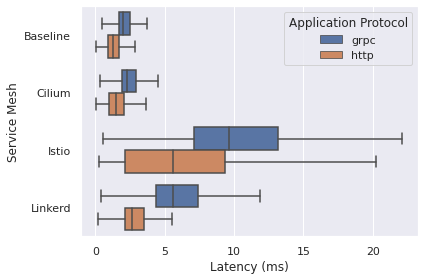

In [27]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies
"""

file_name = f"{file_prefix}-latency-compared.pdf"

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="latency", y="mesh", hue="protocol", order=["Baseline", "Cilium", "Istio", "Linkerd"], showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")

# ax.set_xscale("log")
ax.legend(title="Application Protocol")
fig.tight_layout()
fig.savefig(plot_dir / file_name)

In [18]:
# The quantiles to plot
quantiles = [
    0.99,
    0.999,
    0.9999
]

data = df.groupby(["mesh", "protocol"])["latency"].quantile(quantiles)
data = data.reset_index().rename(columns={"level_2": "percentile"})
data["percentile"] *= 100
data.head()

,mesh,protocol,percentile,latency
0,Baseline,grpc,99.00,8.699719
1,Baseline,grpc,99.90,17.348388
2,Baseline,grpc,99.99,67.603146
3,Baseline,http,99.00,7.420944
4,Baseline,http,99.90,12.984117


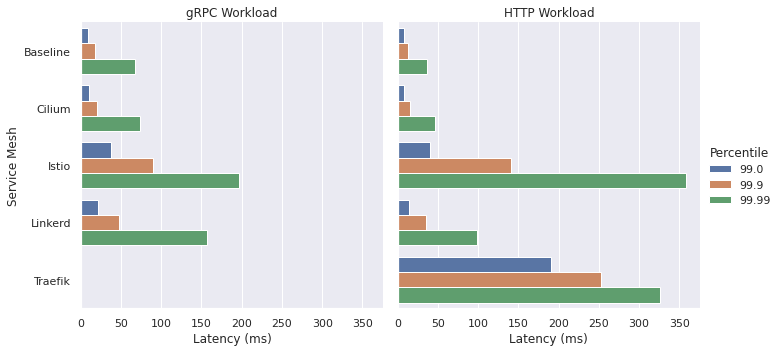

In [25]:
"""
PLOT: Tail End Latencies
"""

# Plotting
file_name = f"{file_prefix}-tail-latencies-all-compared.pdf"

g = sns.catplot(data=data, y="mesh", x="latency", hue="percentile", col="protocol", kind="bar")

axes = g.axes.flatten()

g.set_axis_labels("Latency (ms)", "Service Mesh")
# g.set_axis_labels("Service Mesh","Latency (ms)")
axes[0].set_title("gRPC Workload")
axes[1].set_title("HTTP Workload")
# axes[1].set_title("10Kb Payload")
# axes[3].set_title("1000 Request/s")

g.legend.set_title("Percentile")

g.figure.savefig(plot_dir / file_name)